# 商品销售 - 时间序列预测 

## 概述

**比赛目标**

在这次“入门”竞赛中，您将使用时间序列预测，根据厄瓜多尔大型杂货零售商 Corporación Favorita 的数据来预测商店销售额。具体来说，您将构建一个模型，更准确地预测不同 Favorita 商店销售的数千种商品的单位销售额。您将使用包含日期、商店和商品信息、促销和单位销售额的简单训练数据集来练习您的机器学习技能。

**开始使用**

我们强烈推荐时间序列课程，它将指导您如何进行首次提交。本课程中的课程灵感来自过去 Kaggle 时间序列预测竞赛中的获奖解决方案。

**语境**

预测不仅仅是气象学家的任务。政府预测经济增长。科学家试图预测未来人口。企业预测产品需求——这是专业数据科学家的常见任务。预测对于实体杂货店尤其重要，它们必须小心谨慎地考虑购买多少库存。如果预测稍高，杂货店就会陷入库存过剩和易腐烂商品的困境。如果预测稍低，畅销商品就会很快售罄，导致收入损失和客户不满。借助机器学习，更准确的预测可以帮助确保零售商在合适的时间提供足够的合适产品，从而取悦客户。

目前零售业的主观预测方法几乎没有数据支持，而且不太可能实现自动化。随着零售商增加新店面，满足独特需求、推出新产品、不断变化季节性口味和不可预测的产品营销，问题变得更加复杂。

**潜在影响**

如果成功，您将在现实世界中运用一些新技能。对于杂货店来说，更准确的预测可以减少因库存过剩而导致的食物浪费，并提高客户满意度。随着时间的推移，这种持续竞争的结果甚至可能确保您的当地商店在您下次购物时拥有您所需的一切。


**数据集描述**

在本次比赛中，您将预测厄瓜多尔 Favorita 商店销售的数千个产品系列的销量。训练数据包括日期、商店和产品信息、该商品是否正在促销以及销售数字。其他文件包括可能有助于您构建模型的补充信息。

**文件描述和数据字段信息**

1. **train.csv**
   - 包含时间序列的训练数据，包括特征 `store_nbr`、`family` 和 `onpromotion`，以及目标销售额。
     - `store_nbr`: 标识销售产品的商店。
     - `family`: 标识所售产品的类型。
     - `sales`: 给出特定商店在特定日期的产品系列总销售额。由于产品可以以小数单位出售（例如，1.5 公斤奶酪，而不是 1 袋薯片），因此可以使用小数值。
     - `onpromotion`: 给出在特定日期在商店促销的产品系列中的产品总数。

2. **test.csv**
   - 测试数据具有与训练数据相同的特征。您将预测此文件中日期的目标销售额。
   - 测试数据中的日期是训练数据中最后一个日期之后的 15 天。

3. **sample_submission.csv**
   - 正确格式的示例提交文件。

4. **stores.csv**
   - 包含商店的元数据，包括城市、州、类型和集群。
     - `集群`: 是类似商店的分组。

5. **oil.csv**
   - 包含每日油价。包括训练和测试数据时间范围内的值。（厄瓜多尔是一个依赖石油的国家，其经济状况极易受到油价冲击的影响。）

6. **holidays_events.csv**
   - 包含节日和活动的元数据。
     - **特别注意**`transferred`列。转移的假日正式落在日历日，但被政府移至另一日期。转移日更像是普通日而非假日。要查找实际庆祝的日期，请查找类型为“Transfer”的相应行。
     - 例如，瓜亚基尔独立日从 2012-10-09 转移到 2012-10-12，这意味着它是在 2012-10-12 庆祝的。类型为`过渡`的假日是添加到假日中的额外假日。
     - 其他假日相关说明：
       - **额外假期**: 在常规日历假期中添加的天数。
       - **公共部门工资发放**: 每两周发放一次，分别在每月 15 日和最后一天，超市销售可能受此影响。
       - **地震事件**: 2016 年 4 月 16 日，厄瓜多尔发生里氏 7.8 级地震，影响了震后数周的超市销售。

**文件信息**
- **文件总数**: 7 个
- **数据集大小**: 124.76 MB
- **数据集类型**: 源文件
- **执照**: 遵守比赛规则

## 导入库

In [310]:
import os
import warnings
import itertools 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import plotly.graph_objects as go
from matplotlib_venn import venn2
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import FitFailedWarning
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [281]:
def view_style(df):
    styled_view_df = (df.style
        .set_properties(**{'text-align': 'center', 'color': 'green'})  # 正文绿色 # type: ignore
        .set_table_attributes('style="font-weight: bold;"')  # 行列标签红色加粗
    )

    return styled_view_df

def view_df_base_info(df: pd.DataFrame):
    view_df = pd.DataFrame({
        '数据类型': df.dtypes.values, 
        '最大值': df.max().values, 
        '最小值': df.min().values, 
        '缺失占比': df.isnull().mean(),
        '属性数量': df.nunique(),
        '最大属性占比': df.apply(lambda x: f"{x.value_counts(normalize=True, dropna=False).values[0]:.2f}")
    })
    
    return view_style(view_df)


def count_unique_index_levels(df: pd.DataFrame):
    # 获取多重索引的每个级别的种类数量
    unique_counts = {level: df.index.get_level_values(level).nunique() for level in df.index.names}
    
    # 添加总行数
    unique_counts['总行数'] = df.shape[0]
    
    return  view_style(pd.DataFrame.from_dict(unique_counts, orient='index', columns=['数量']))

## 数据加载 

In [282]:
if not os.path.exists("./data"):
    !kaggle competitions download -c store-sales-time-series-forecasting
    !mkdir ./data
    !unzip *.zip -d ./data/
    !rm -rf *.zip

In [283]:
train = pd.read_csv('./data/train.csv', parse_dates=['date'],  converters={'onpromotion': lambda x : bool(int(x))})
test = pd.read_csv('./data/test.csv', parse_dates=['date'],  converters={'onpromotion': lambda x : bool(int(x))})
holidays_envents = pd.read_csv('./data/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('./data/transactions.csv')
oil = pd.read_csv("./data/oil.csv", parse_dates=['date'])
stores = pd.read_csv("./data/stores.csv")

### train.csv & test.csv

In [284]:
count_unique_index_levels(train)

,数量
None,3000888
总行数,3000888


In [285]:
count_unique_index_levels(test)

,数量
None,28512
总行数,28512


In [286]:
view_df_base_info(train)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
id,int64,3000887,0,0.000000,3000888,0.00
date,datetime64[ns],2017-08-15 00:00:00,2013-01-01 00:00:00,0.000000,1684,0.00
store_nbr,int64,54,1,0.000000,54,0.02
family,object,SEAFOOD,AUTOMOTIVE,0.000000,33,0.03
sales,float64,124717.000000,0.000000,0.000000,379610,0.31
onpromotion,bool,True,False,0.000000,2,0.80


In [287]:
view_df_base_info(test)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
id,int64,3029399,3000888,0.000000,28512,0.00
date,datetime64[ns],2017-08-31 00:00:00,2017-08-16 00:00:00,0.000000,16,0.06
store_nbr,int64,54,1,0.000000,54,0.02
family,object,SEAFOOD,AUTOMOTIVE,0.000000,33,0.03
onpromotion,bool,True,False,0.000000,2,0.56


### oil.csv

In [288]:
view_df_base_info(oil)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
date,datetime64[ns],2017-08-31 00:00:00,2013-01-01 00:00:00,0.000000,1218,0.00
dcoilwtico,float64,110.620000,26.190000,0.035304,998,0.04


In [289]:
oil.index

RangeIndex(start=0, stop=1218, step=1)

In [290]:
count_unique_index_levels(oil)

,数量
None,1218
总行数,1218


In [291]:
view_df_base_info(oil
    .set_index('date')  # 将index设置为date
    .resample('D').asfreq()   # 将日期重采样为每日
    .interpolate(method='linear')   # 线性插值
    .bfill().ffill()    # 首尾缺失插值
    .reset_index()  # 下标重排序
)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
date,datetime64[ns],2017-08-31 00:00:00,2013-01-01 00:00:00,0.000000,1704,0.00
dcoilwtico,float64,110.620000,26.190000,0.000000,1495,0.00


### stores.csv

In [292]:
view_df_base_info(stores)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
store_nbr,int64,54,1,0.000000,54,0.02
city,object,Santo Domingo,Ambato,0.000000,22,0.33
state,object,Tungurahua,Azuay,0.000000,16,0.35
type,object,E,A,0.000000,5,0.33
cluster,int64,17,1,0.000000,17,0.13


In [293]:
stores['state'].unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

> 各州名称

### transactions.csv

In [294]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### holidays_events.csv

In [295]:
view_df_base_info(holidays_envents)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
date,datetime64[ns],2017-12-26 00:00:00,2012-03-02 00:00:00,0.000000,312,0.01
type,object,Work Day,Additional,0.000000,6,0.63
locale,object,Regional,Local,0.000000,3,0.50
locale_name,object,Santo Domingo de los Tsachilas,Ambato,0.000000,24,0.50
description,object,Viernes Santo,Batalla de Pichincha,0.000000,103,0.03
transferred,bool,True,False,0.000000,2,0.97


In [296]:
holidays_envents.tail(10)

,date,type,locale,locale_name,description,transferred
340,2017-12-06,Holiday,Local,Quito,Fundacion de Quito,True
341,2017-12-08,Holiday,Local,Loja,Fundacion de Loja,False
342,2017-12-08,Transfer,Local,Quito,Traslado Fundacion de Quito,False
343,2017-12-21,Additional,National,Ecuador,Navidad-4,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [297]:
count_unique_index_levels(holidays_envents)

,数量
None,350
总行数,350


In [298]:
holidays_envents['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

> “假期”、“调动”、“额外”、“过渡”、“工作日”、“活动” 

In [299]:
holidays_envents['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

> locale: Local(本地/city), Regional(区域/state), National(全国)

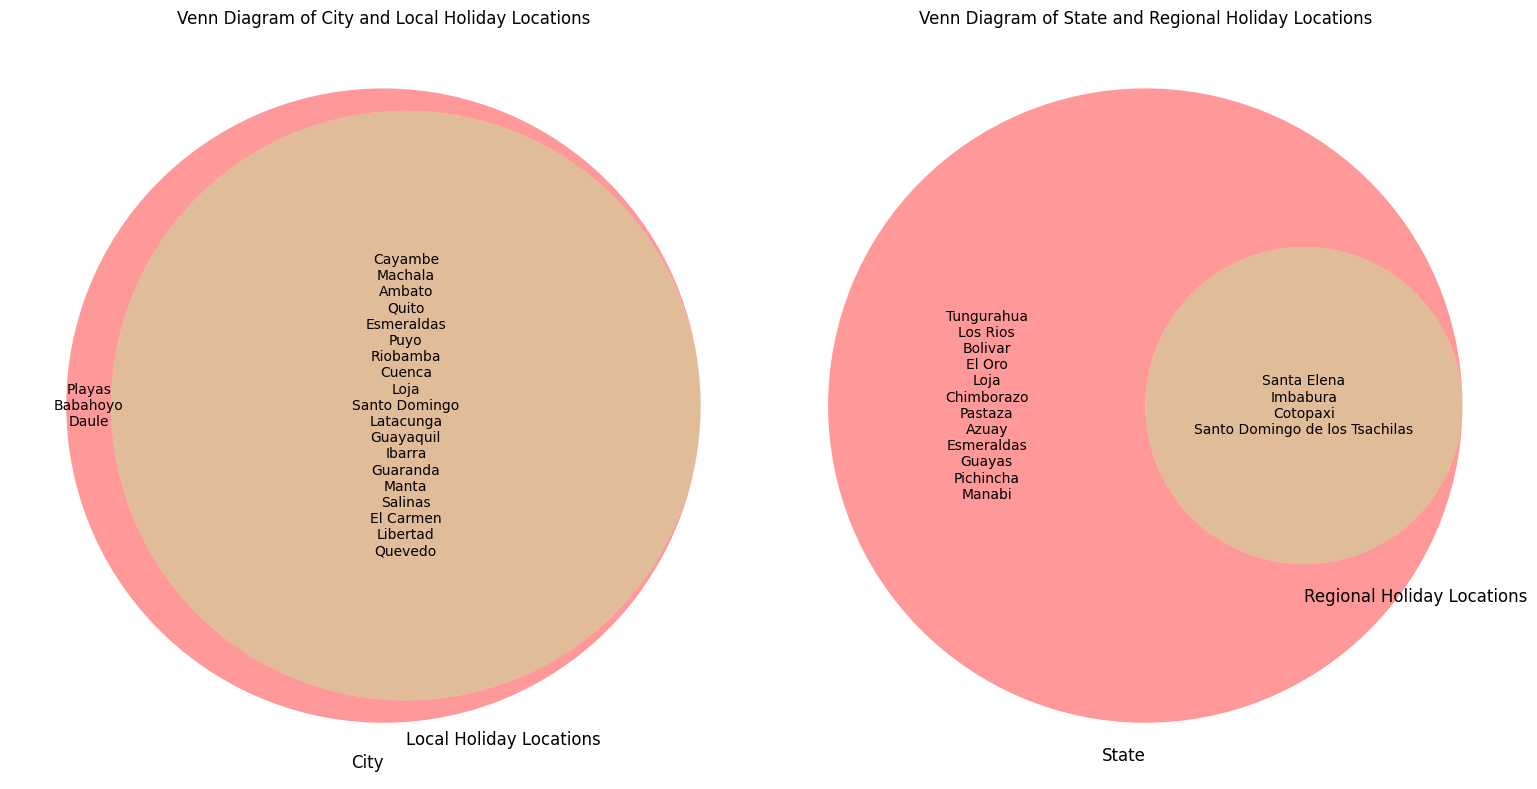

In [300]:
def plot_venn(ax, stores, holidays_events, location_type, entity_name):
    # 获取唯一城市或州的名称
    if entity_name == 'city':
        entities = stores['city'].unique()
    elif entity_name == 'state':
        entities = stores['state'].unique()
    
    # 根据 locale 筛选出假期地点
    locale_names = holidays_events[holidays_events['locale'] == location_type]['locale_name'].unique()
    
    # 转换为集合
    entity_set = set(entities)
    locale_set = set(locale_names)
    
    # 计算交集
    intersection = entity_set.intersection(locale_set)
    
    # 创建标签
    labels = {
        '10': '\n'.join(entity_set - locale_set),  # 仅在实体集合中的名称
        '01': '\n'.join(locale_set - entity_set),   # 仅在假期地点集合中的名称
        '11': '\n'.join(intersection)              # 同时在两个集合中的名称
    }
    
    # 绘制韦恩图
    venn = venn2([entity_set, locale_set], (entity_name.capitalize(), f"{location_type} Holiday Locations"), ax=ax)
    
    # 添加具体名称作为标签
    for idx, label in labels.items():
        venn.get_label_by_id(idx).set_text(label)
    
    ax.set_title(f"Venn Diagram of {entity_name.capitalize()} and {location_type} Holiday Locations")

# 创建画布和两个子图
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 在第一张子图上绘制 Local 假期韦恩图 (city)
plot_venn(axes[0], stores, holidays_envents, 'Local', 'city')

# 在第二张子图上绘制 Regional 假期韦恩图 (state)
plot_venn(axes[1], stores, holidays_envents, 'Regional', 'state')

# 显示图像
plt.tight_layout()
plt.show()

> 可以看出, stores中的city和 holidays_envents中的Local对应, state 和 Regional 对应 

### 合并数据

In [301]:
del train
del test
# del oil
del transactions
del holidays_envents
del stores

In [302]:
def concat_citys(holidays_envents:pd.DataFrame, unique_cities_states: pd.DataFrame):
    # 创建一个空的列表来存储所有节假日信息
    all_holidays = []

    # 处理每一行
    for _, row in holidays_envents.iterrows():
        if row['locale'] == 'Local':
            # 对于本地节日，直接使用城市名称
            all_holidays.append({
                'city': row['locale_name'],
                'state': unique_cities_states.loc[unique_cities_states['city'] == row['locale_name'], 'state'].values[0],
                'date': row['date'],
                'festival_type': row['type'],
                'description': row['description'],
                'transferred': row['transferred']
            })
        elif row['locale'] == 'Regional':
            # 对于区域节日，找到对应州的城市并添加
            state_cities = unique_cities_states[unique_cities_states['state'] == row['locale_name']]
            for _, city_row in state_cities.iterrows():
                all_holidays.append({
                    'city': city_row['city'],
                    'state': row['locale_name'],
                    'date': row['date'],
                    'festival_type': row['type'],
                    'description': row['description'],
                    'transferred': row['transferred']
                })
        elif row['locale'] == 'National':
            # 对于国家节日，将所有城市和州添加
            for _, city_row in unique_cities_states.iterrows():
                all_holidays.append({
                    'city': city_row['city'],
                    'state': city_row['state'],
                    'date': row['date'],
                    'festival_type': row['type'],
                    'description': row['description'],
                    'transferred': row['transferred']
                })

    # 创建最终的 DataFrame
    all_holidays = pd.DataFrame(all_holidays)
    
    return all_holidays

In [303]:
def read_data(_type='train'):
    
    params = dict(parse_dates=['date'],  converters={'onpromotion': lambda x : bool(int(x))})
    
    df = pd.read_csv("./data/train.csv", **params) if _type == 'train' else pd.read_csv('./data/test.csv', **params)
    oil_df = pd.read_csv('./data/oil.csv', parse_dates=['date'])
    stores_df = pd.read_csv('./data/stores.csv')
    transactions_df = pd.read_csv('./data/transactions.csv', parse_dates=['date'])
    holidays_envents_df = pd.read_csv('./data/holidays_events.csv', parse_dates=['date'])

    unique_cities_states = stores_df[['city', 'state']].drop_duplicates()
    all_holidays = concat_citys(holidays_envents_df, unique_cities_states)

    oil_df = (oil_df
        .set_index('date')  # 将index设置为date
        .resample('D').asfreq()   # 将日期重采样为每日
        .interpolate(method='linear')   # 线性插值
        .bfill().ffill()    # 首尾缺失插值
        .reset_index()  # 下标重排序
    )

    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')
    df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
    df = df.merge(all_holidays, on=['date', 'state', 'city'], how='left')

    df.set_index(['date', 'family', 'store_nbr'], inplace=True)

    # 获取日期层的值
    date_values = df.index.get_level_values('date')
    # 条件筛选
    is_15th_or_last_day = (date_values.day == 15) | date_values.isin(
        date_values.to_period('M').drop_duplicates(keep='last').to_timestamp()
    )
    # 直接在 train_df 上进行赋值操作
    df.loc[is_15th_or_last_day, 'festival_type'] = 'Salary Day'

    df['festival_type'] = df['festival_type'].fillna('Work Day')
    df['description'] = df['description'].fillna('-')
    df['transferred'] = df['transferred'].fillna(False)
    
    return df.drop(columns=['transactions'])

In [304]:
test_df = read_data('test')
train_df = read_data()

In [305]:
view_df_base_info(train_df)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
id,int64,3000887,0,0.000000,3000888,0.00
sales,float64,124717.000000,0.000000,0.000000,379610,0.31
onpromotion,bool,True,False,0.000000,2,0.80
dcoilwtico,float64,110.620000,26.190000,0.000000,1484,0.00
city,object,Santo Domingo,Ambato,0.000000,22,0.33
state,object,Tungurahua,Azuay,0.000000,16,0.35
type,object,E,A,0.000000,5,0.33
cluster,int64,17,1,0.000000,17,0.13
transactions,float64,8359.000000,5.000000,0.081799,4993,0.08
festival_type,object,Work Day,Additional,0.000000,7,0.85


In [191]:
count_unique_index_levels(train_df)

,数量
date,1684
family,33
store_nbr,54
总行数,3008775


In [192]:
view_df_base_info(test_df)

,数据类型,最大值,最小值,缺失占比,属性数量,最大属性占比
id,int64,3029399,3000888,0.000000,28512,0.00
onpromotion,bool,True,False,0.000000,2,0.56
dcoilwtico,float64,48.590000,45.960000,0.000000,15,0.12
city,object,Santo Domingo,Ambato,0.000000,22,0.33
state,object,Tungurahua,Azuay,0.000000,16,0.35
type,object,E,A,0.000000,5,0.33
cluster,int64,17,1,0.000000,17,0.13
festival_type,object,Work Day,Holiday,0.000000,2,1.00
description,object,Fundacion de Ambato,-,0.000000,2,1.00
transferred,bool,False,False,0.000000,1,1.00


In [193]:
train_df['festival_type'].unique()

array(['Salary Day', 'Work Day', 'Holiday', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

## 探索性分析

### 时间序列基本特性分析

In [194]:
store_nbr_names, familys = train_df.index.get_level_values('store_nbr').unique(), train_df.index.get_level_values('family').unique()

In [195]:
store_nbr_names, familys

(Index([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4, 40, 41,
        42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,  7,  8,  9],
       dtype='int64', name='store_nbr'),
 Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
        'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
        'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
        'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
        'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
        'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
        'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
        'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
       dtype='object', name='family'))

In [196]:
store_nbr_names.shape, familys.shape

((54,), (33,))

In [197]:
sample_df = (train_df
    .query("family == @familys[2] and store_nbr == @store_nbr_names[0]")
    .reset_index(['family', 'store_nbr'], drop=True)
    # .assign(date= lambda df: df.index)
    # .reset_index(drop=True)
)

In [198]:
sample_df.head()

,id,sales,onpromotion,dcoilwtico,city,state,type,cluster,festival_type,description,transferred
date,,,,,,,,,,,
2013-01-01,2,0.0,False,93.140000,Quito,Pichincha,D,13,Salary Day,Primer dia del ano,False
2013-01-02,1784,2.0,False,93.140000,Quito,Pichincha,D,13,Work Day,-,False
2013-01-03,3566,0.0,False,92.970000,Quito,Pichincha,D,13,Work Day,-,False
2013-01-04,5348,3.0,False,93.120000,Quito,Pichincha,D,13,Work Day,-,False
2013-01-05,7130,3.0,False,93.146667,Quito,Pichincha,D,13,Work Day,Recupero puente Navidad,False


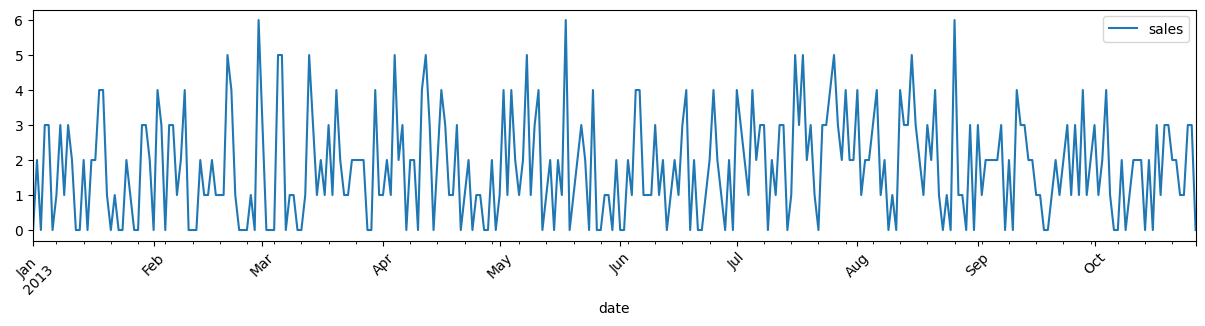

In [199]:
sample_df.iloc[:300, :][['sales']].plot(figsize=(15, 3))
plt.xticks(rotation=45)
plt.show()

#### 平稳性检验

In [200]:
result = adfuller(sample_df['sales'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items(): # type: ignore
    print('Critical Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.2521992911067565
p-value: 0.0005369391409001367
Critical Values:
   1%, -3.4342906911169404
Critical Values:
   5%, -2.8632805908715726
Critical Values:
   10%, -2.5676966486957706


> 序列是平稳的

#### 自相关性

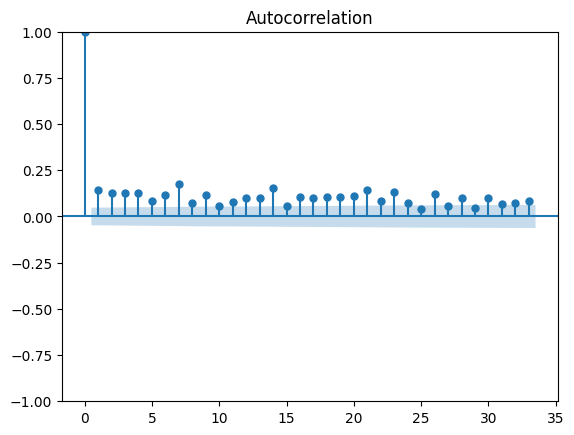

In [201]:
plot_acf(sample_df['sales'])
plt.show()

> 可以看出, 该序列有明显的季节性

#### 趋势分析

In [202]:
sample_df['sales_mean'] = sample_df['sales'].rolling(7).mean()
sample_df['sales_var'] = sample_df['sales'].rolling(7).std()

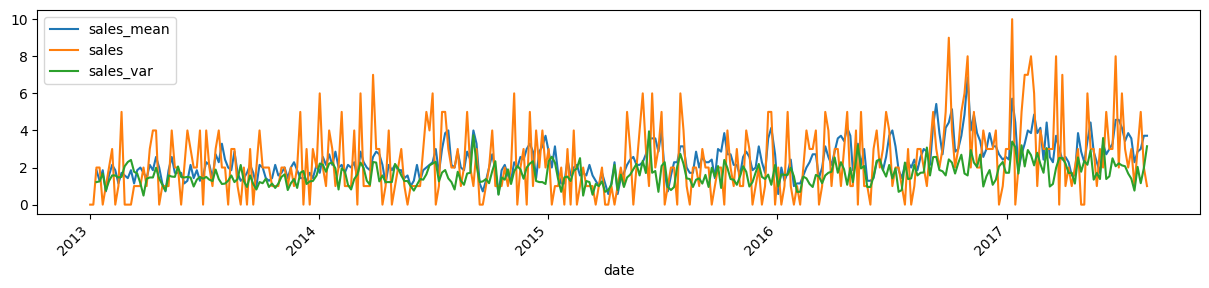

In [203]:
sample_df[['sales_mean', 'sales', 'sales_var']].iloc[::5].plot(figsize=(15, 3))
plt.xticks(rotation=45)
plt.show()

> 平稳序列, 没有趋势

#### 季节性分析

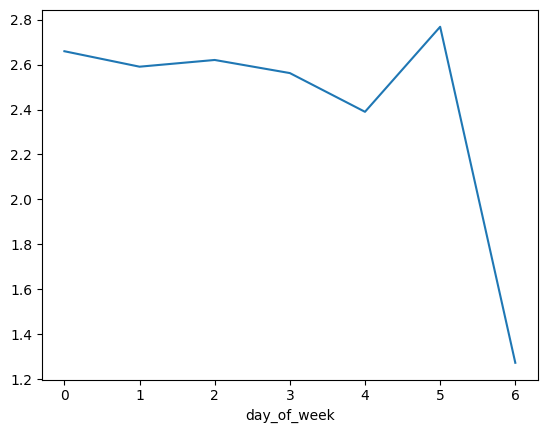

In [204]:
sample_df['day_of_week'] = pd.to_datetime(sample_df.index.values).dayofweek
day_of_week = sample_df.groupby(by='day_of_week')['sales'].mean()
day_of_week.plot()
plt.show()

> 可以看出, 有明显性的周季节变化

In [205]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

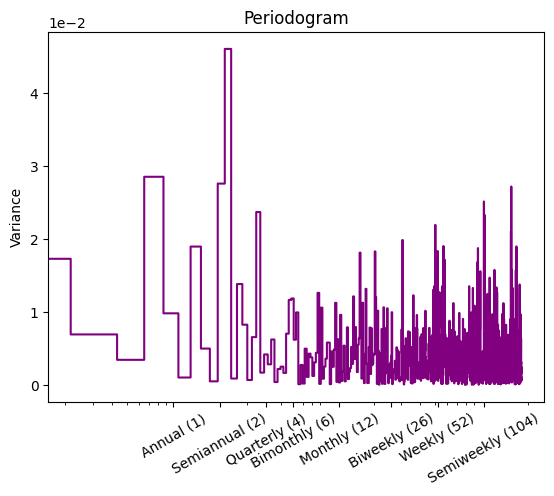

In [206]:
plot_periodogram(sample_df.sales)
plt.show()

> 显然, 从频谱图中可以看出, 周季节性比较明显

In [207]:
sample_df.columns

Index(['id', 'sales', 'onpromotion', 'dcoilwtico', 'city', 'state', 'type',
       'cluster', 'festival_type', 'description', 'transferred', 'sales_mean',
       'sales_var', 'day_of_week'],
      dtype='object')

#### 针对所有商品进行该项分析

In [208]:
sales_df = (train_df
            .groupby(level=['date'])[['sales']]
            .mean()
)

In [209]:
sales_df.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


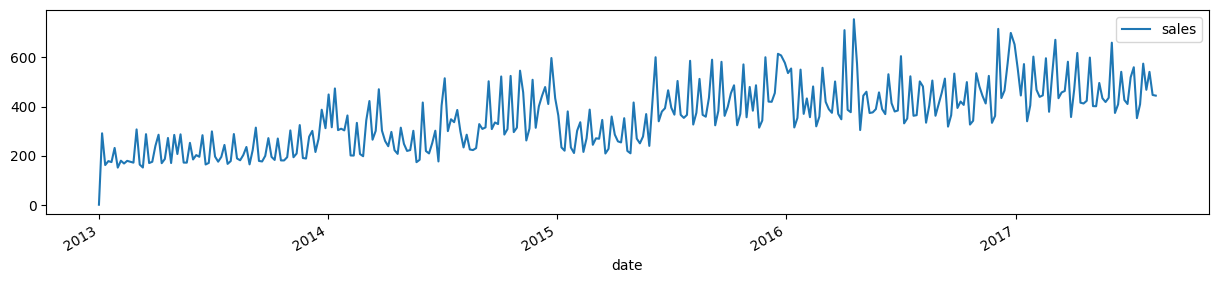

In [210]:
sales_df.iloc[::5].plot(figsize=(15, 3))
plt.show()

In [211]:
adfuller(sales_df)

(-2.6177281178682232,
 0.08938830129469394,
 22,
 1661,
 {'1%': -3.4342930672797065,
  '5%': -2.8632816397229064,
  '10%': -2.567697207194407},
 18026.11692521414)

> 有点不平稳性

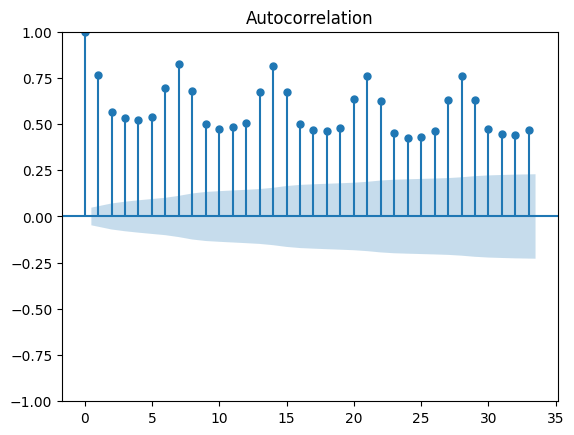

In [212]:
plot_acf(sales_df)
plt.show()

> 同样呈现出明显的季节性特征

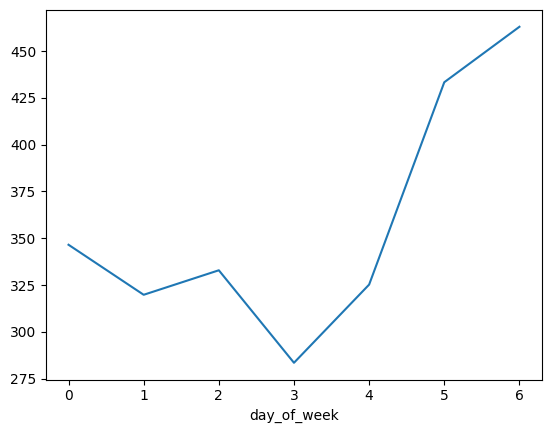

In [213]:
sales_df['day_of_week'] = pd.to_datetime(sales_df.index.values).dayofweek
day_of_week = sales_df.groupby(by='day_of_week')['sales'].mean()
day_of_week.plot()
plt.show()

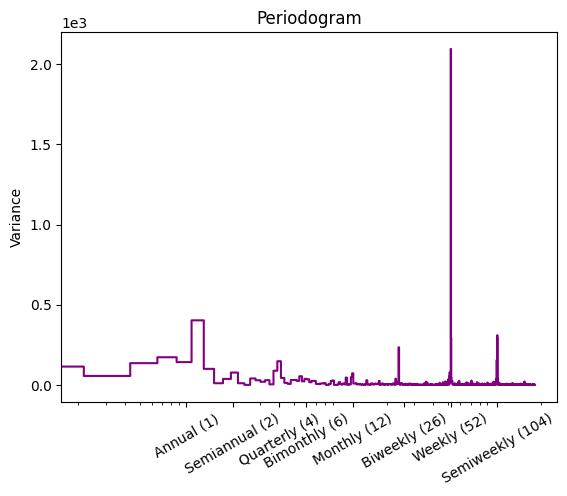

In [214]:
plot_periodogram(sales_df.sales)
plt.show()

> 结论: 商品销售单价存在周季节性, 但是每个商品的周季节性变化趋势都不太相同

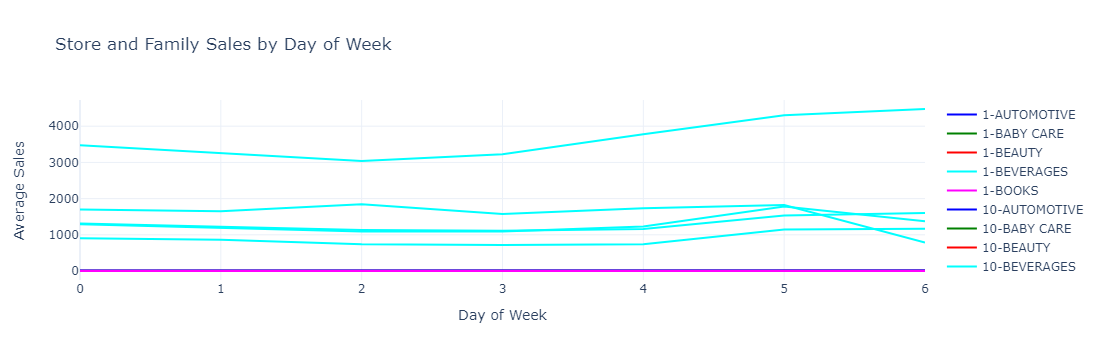

In [215]:
fig = go.Figure()

# 定义不同颜色的线条
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# 添加数据线条
for i, (store_nbr_name, family) in enumerate(itertools.product(store_nbr_names[:5], familys[:5])):
    sample_df = (train_df
                 .query("family == @family and store_nbr == @store_nbr_name")
                 .reset_index(['family', 'store_nbr'], drop=True)
    )
    sample_df['day_of_week'] = pd.to_datetime(sample_df.index.values).dayofweek
    day_of_week = sample_df.groupby(by='day_of_week')['sales'].mean()

    # 将每一条线加到图上，并为每个曲线设置名称和颜色
    fig.add_trace(go.Scatter(x=day_of_week.index, y=day_of_week, mode='lines',
                             name=f'{store_nbr_name}-{family}', 
                             line=dict(color=colors[i % len(colors)])))

# 设置图表布局
fig.update_layout(
    title="Store and Family Sales by Day of Week",
    xaxis_title="Day of Week",
    yaxis_title="Average Sales",
    template="plotly_white",
    hovermode="x unified"  # 悬停时同时显示所有线条的值
)

# 显示图表
fig.show()

In [216]:
test_store_nbr_names, test_familys = test_df.index.get_level_values(level='store_nbr').unique(), test_df.index.get_level_values(level='family').unique(), 

In [217]:
test_store_nbr_names.shape, test_familys.shape

((54,), (33,))

In [218]:
pvalues = {}
for i, (store_nbr_name, family) in enumerate(itertools.product(store_nbr_names[:5], familys[:5])):
    sample_df = train_df.query("(family == @family) and (store_nbr == @store_nbr_name)")
    try:
        pvalues[f"{store_nbr_name}_{family}"] = adfuller(sample_df['sales'])[1]
    except:
        pass
pvalues = pd.Series(pvalues)
pvalues.sort_values(ascending=False).head()

1_BOOKS         0.125701
11_BEVERAGES    0.103378
12_BEVERAGES    0.041237
1_BEVERAGES     0.029173
11_BEAUTY       0.020638
dtype: float64

> 整体比较平稳, 个别略存在一定的不平稳性

### 单变量分析

#### 数据分布

In [219]:
def df_distribution(df:pd.DataFrame, drop=None, columns=None):
    if drop is not None:
        num_cols = df.columns.drop(drop)
    elif columns is not None:
        num_cols = columns
    elif columns is None and columns is None:
        num_cols = df.columns
    else:
        raise ValueError("Only one parameter can be passed: `drop` or `columns`, but not both.")

    # 设置画布和子图
    plt.figure(figsize=(15, (len(num_cols) // 3 + 1) * 5))
    # 遍历每一列并绘制分布图
    for i, col in enumerate(num_cols):
        plt.subplot(len(num_cols) // 3 + 1, 3, i + 1)  # 根据列数设置子图
        if df[col].nunique() > 30:
            sns.histplot(df[col], kde=True, bins=30)  # 绘制直方图和核密度估计
        else:
            sns.countplot(data=df, x=col)
            plt.xticks(rotation=45)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Frequency')

    plt.tight_layout()  # 自动调整子图间距
    plt.show()

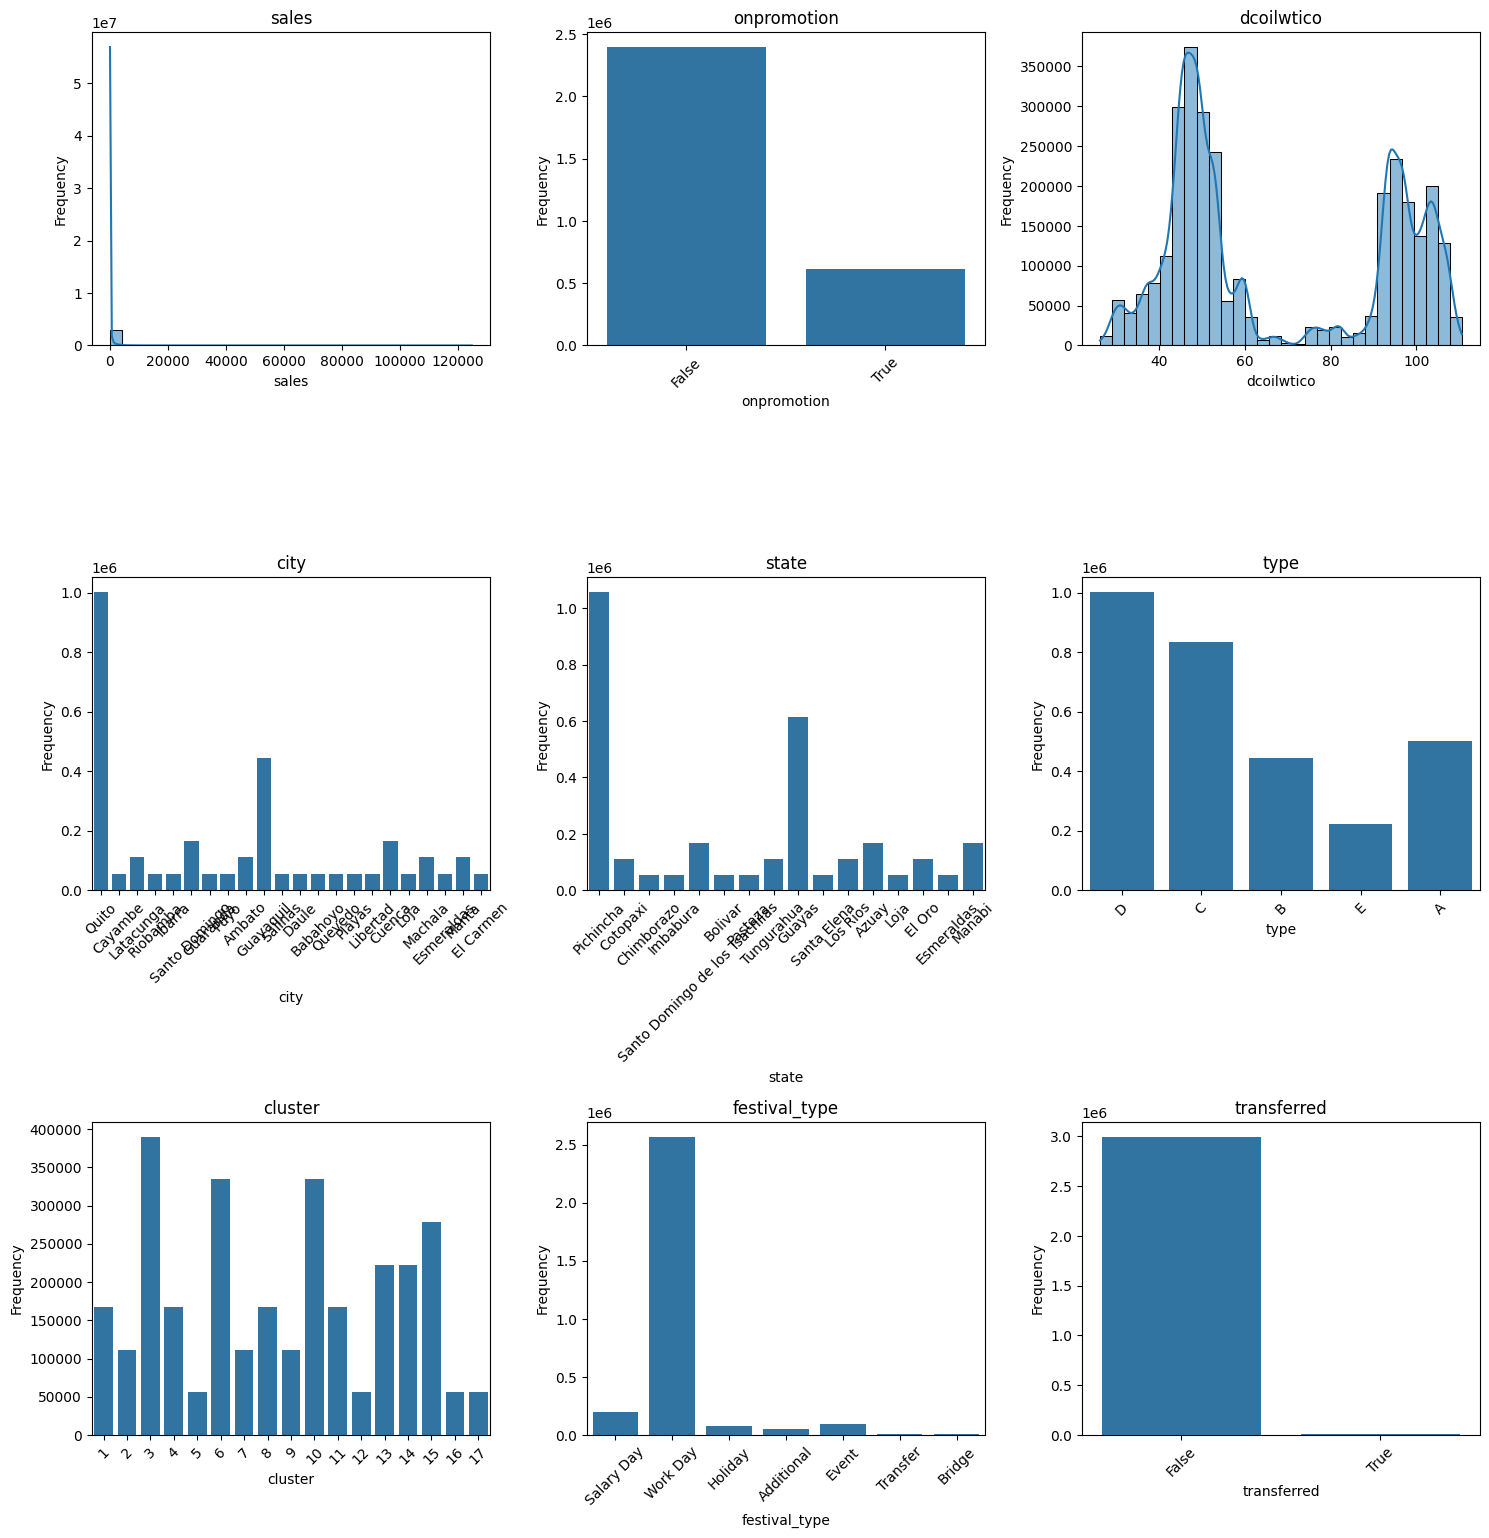

In [220]:
df_distribution(train_df, drop=['id', 'description'])

> sales 偏态分布, 对其进行对数转换

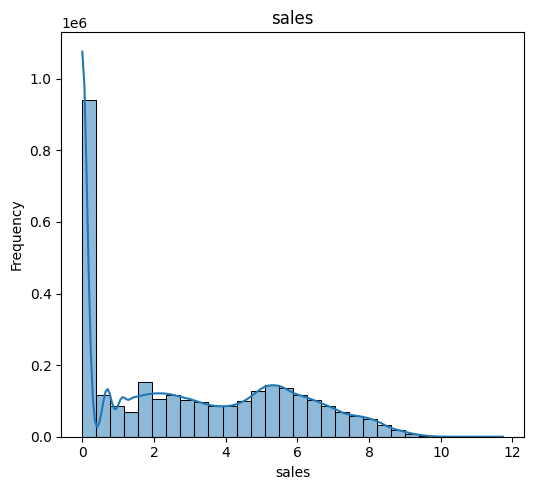

In [221]:
df_distribution(train_df[['sales']].apply(np.log1p))

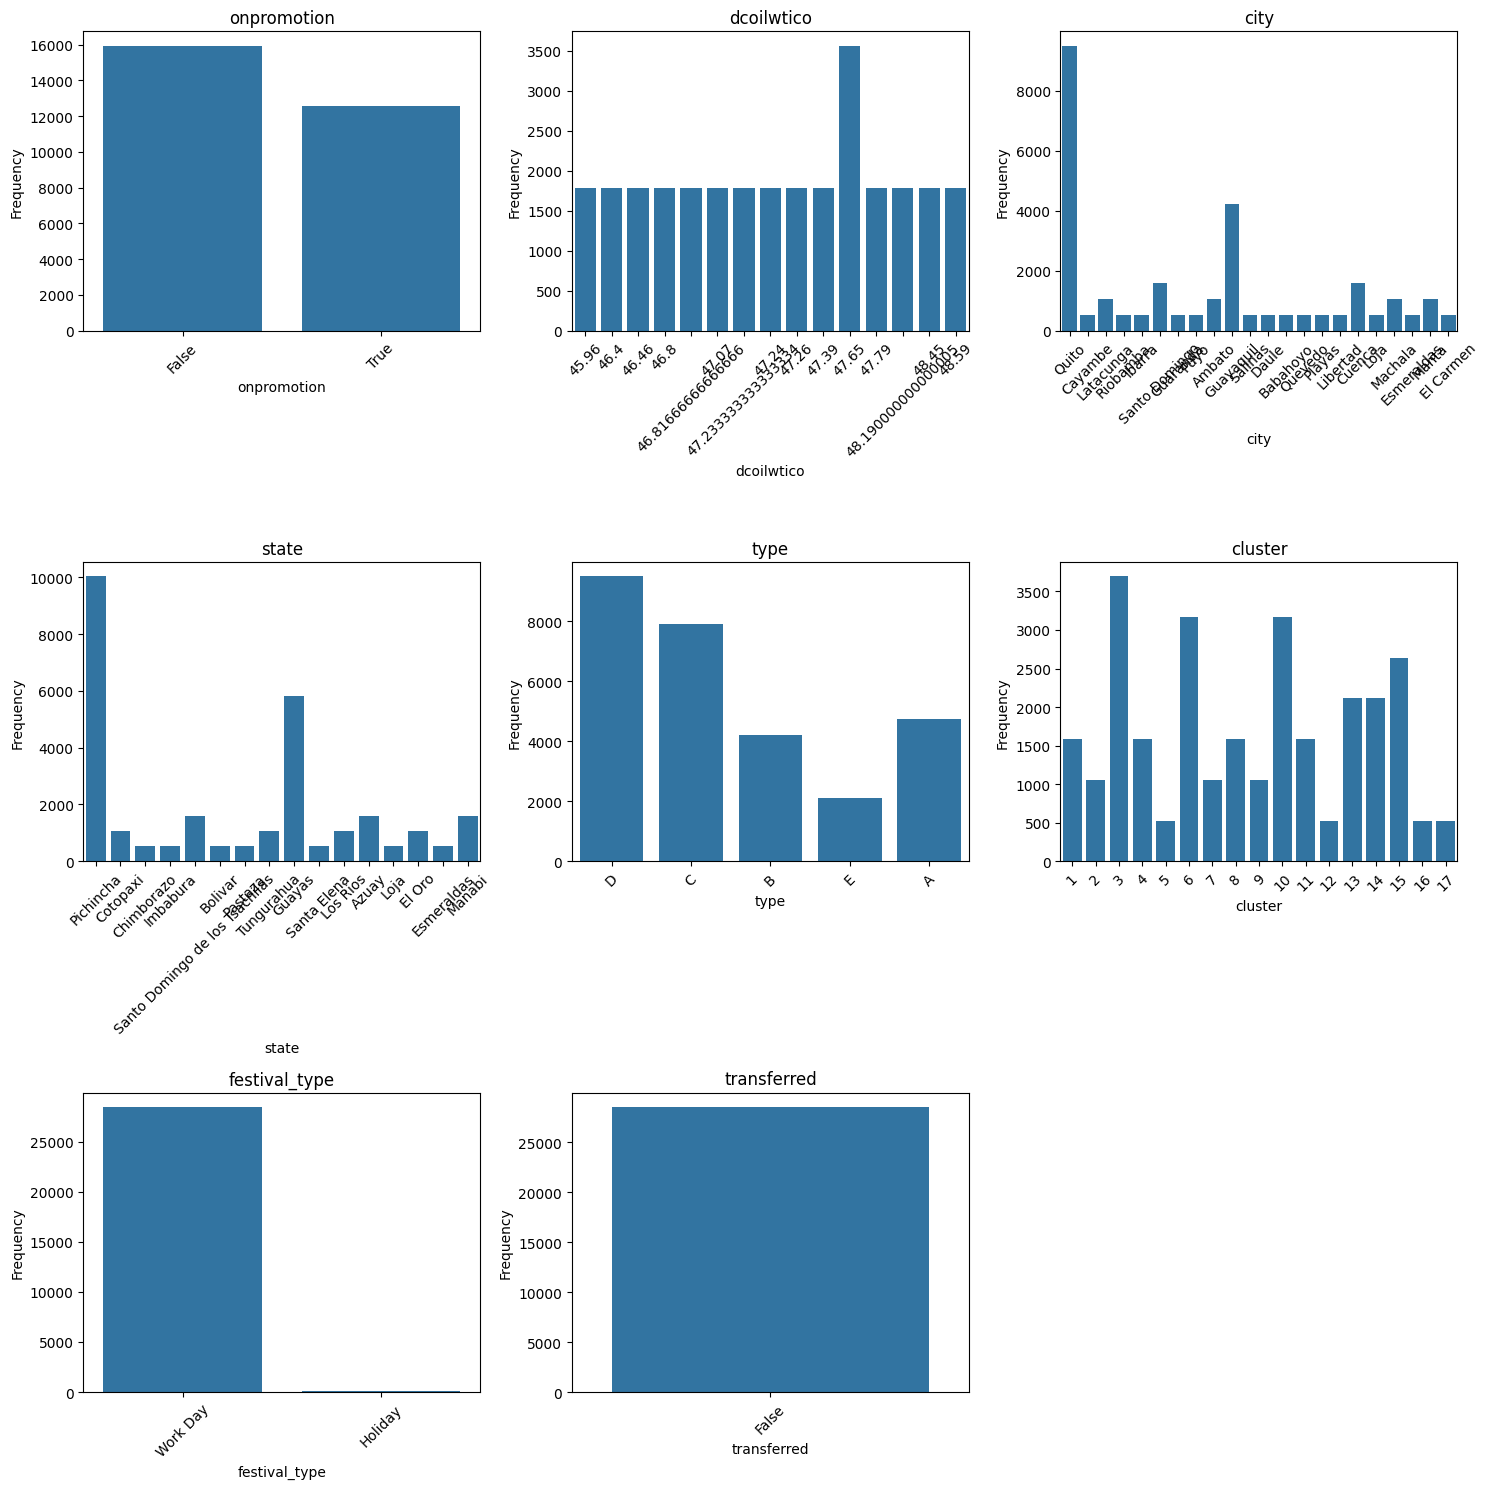

In [222]:
df_distribution(test_df, drop=['id', 'description'])

### 整体销量随日期的变化展示

In [223]:
def total_sales_plot(df :pd.DataFrame):
    ax = df.groupby(level='date')[['sales']].sum().plot(figsize=(16, 5), label='sum sales')
    ax = df[df['onpromotion']].groupby(level='date')[['sales']].sum().plot(label='sales[isonpromotion]', ax=ax)
    ax = df[~df['onpromotion']].groupby(level='date')[['sales']].sum().plot(label='sales[unonpromotion]', ax=ax)
    plt.legend()
    plt.xticks(rotation=45)  # 旋转 x 轴标签以提高可读性
    plt.tight_layout()  # 调整布局
    plt.show()

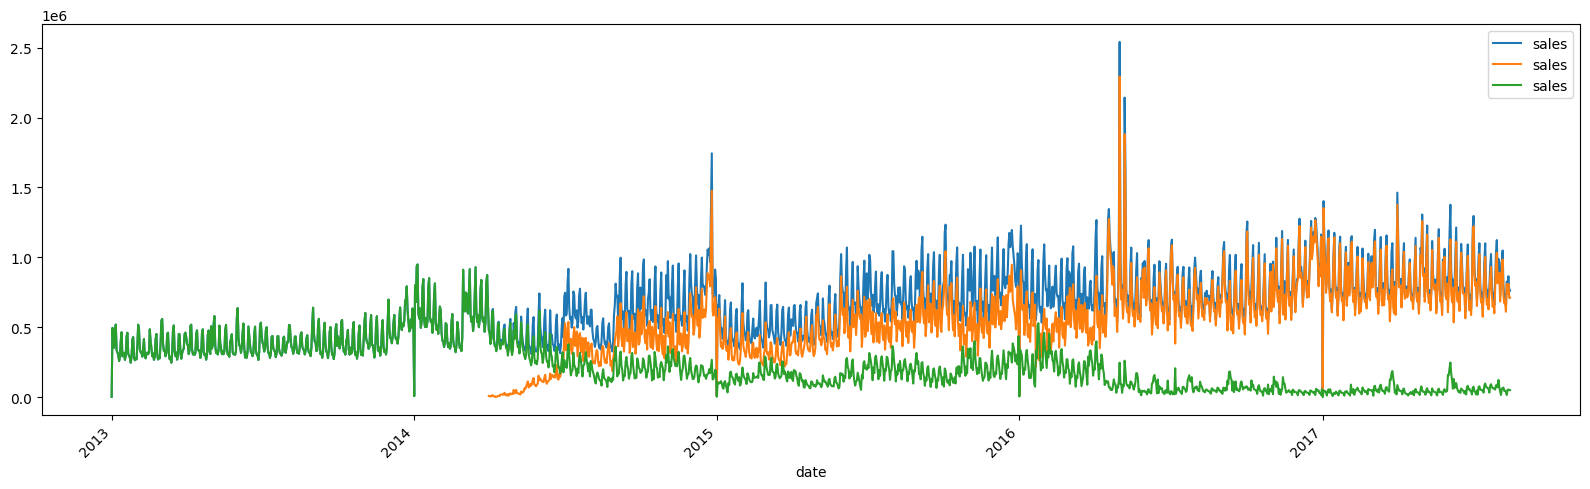

In [224]:
total_sales_plot(train_df)

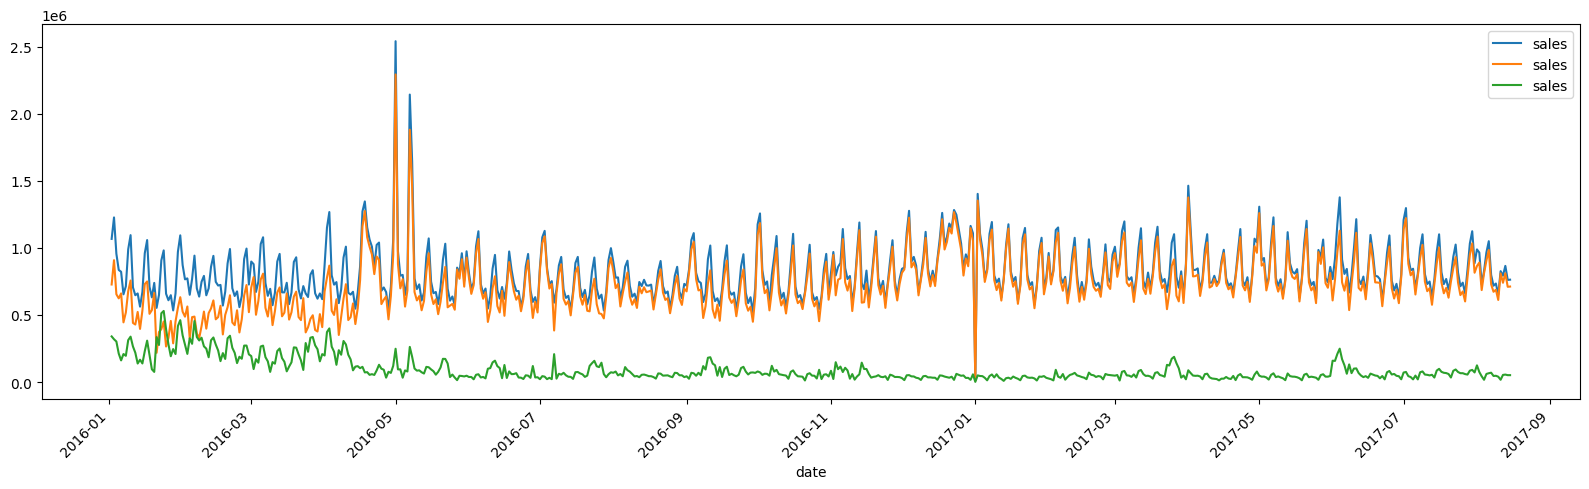

In [225]:
total_sales_plot(train_df.query('date > "2016-01-01"'))

> 商品促销对销售总额有较明显的影响

### 石油价格变化趋势和销售总额趋势对比

In [226]:
oil_stat = (train_df
      .groupby(level='date')[['sales']]
      .sum()
      .rolling(14)  # 对销量进行14日平滑
      .mean()
      .apply(lambda x: (x - x.min()) / (x.max() - x.min()))
)
oil_stat = oil_stat.merge(oil.apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.name == 'dcoilwtico' else x ), on='date', how='left')

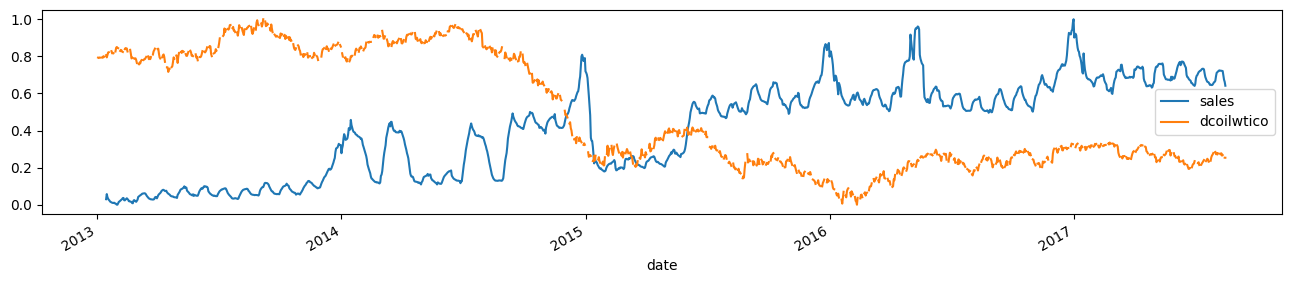

In [227]:
oil_stat.plot(figsize=(16, 3), x='date')
plt.show()

In [228]:
oil_stat.drop(columns='date').corr()

,sales,dcoilwtico
sales,1.000000,-0.786149
dcoilwtico,-0.786149,1.000000


> 比较有趣的一个地方在于, 石油价格的上涨和下跌走势和商品总销量整体呈现相反趋势

### 不同节日的整体平均销量

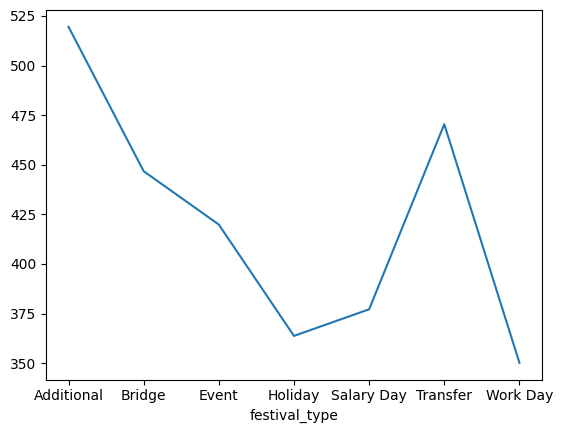

In [229]:
train_df.groupby(by='festival_type')['sales'].mean().plot()
plt.show()

## 统计建模

> 任选一个商店的产品类型, 进行建模预测。 为了检验效果, 从训练集中划分一部分作为验证集

In [230]:
train_sample = read_data()
test_store_nbr_names, test_familys = test_df.index.get_level_values(level='store_nbr').unique(), test_df.index.get_level_values(level='family').unique()
train_sample = train_sample.query("family == @familys[3] and store_nbr == @store_nbr_names[0]")
train_sample['date'] = train_sample.index.get_level_values(level='date')
train_sample = train_sample.reset_index(drop=True)

In [231]:
train_sample.head()

,id,sales,onpromotion,dcoilwtico,city,state,type,cluster,festival_type,description,transferred,date
0,3,0.0,False,93.140000,Quito,Pichincha,D,13,Salary Day,Primer dia del ano,False,2013-01-01
1,1785,1091.0,False,93.140000,Quito,Pichincha,D,13,Work Day,-,False,2013-01-02
2,3567,919.0,False,92.970000,Quito,Pichincha,D,13,Work Day,-,False,2013-01-03
3,5349,953.0,False,93.120000,Quito,Pichincha,D,13,Work Day,-,False,2013-01-04
4,7131,1160.0,False,93.146667,Quito,Pichincha,D,13,Work Day,Recupero puente Navidad,False,2013-01-05


In [232]:
sales_train, sales_vaild = train_sample[['date', 'sales']][:1500], train_sample[['date','sales']][1500:] 

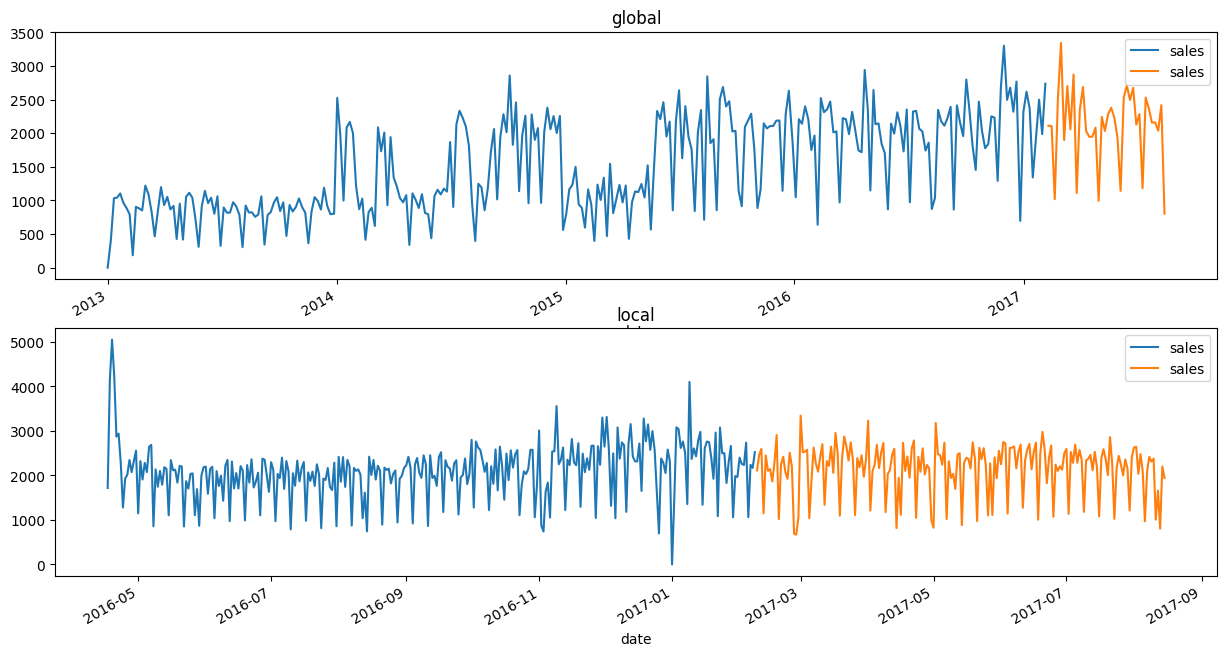

In [233]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15, 8))
axs = axs.ravel()
sales_train.iloc[::5].plot(label='train', x='date', ax=axs[0])
sales_vaild.iloc[::5].plot(ax=axs[0], x='date', label='test')
sales_train.iloc[1200:].plot(label='train', x='date', ax=axs[1])
sales_vaild.iloc[:].plot(ax=axs[1], x='date', label='test')
axs[0].set_title('global')
axs[1].set_title("local")
plt.legend()
plt.show()

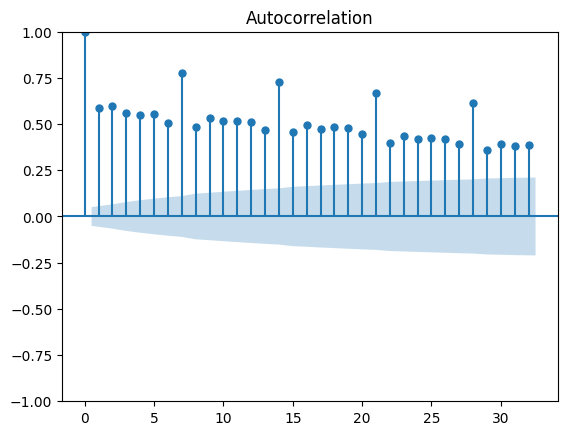

In [234]:
plot_acf(sales_train['sales'])
plt.show()

## 特征工程

id  sales  onpromotion  dcoilwtico   city  \
date       family     store_nbr                                              
2013-01-01 AUTOMOTIVE 1           0    0.0        False       93.14  Quito   
           BABY CARE  1           1    0.0        False       93.14  Quito   
           BEAUTY     1           2    0.0        False       93.14  Quito   
           BEVERAGES  1           3    0.0        False       93.14  Quito   
           BOOKS      1           4    0.0        False       93.14  Quito   

                                     state type  cluster  transactions  \
date       family     store_nbr                                          
2013-01-01 AUTOMOTIVE 1          Pichincha    D       13           NaN   
           BABY CARE  1          Pichincha    D       13           NaN   
           BEAUTY     1          Pichincha    D       13           NaN   
           BEVERAGES  1          Pichincha    D       13           NaN   
           BOOKS      1          Pichincha    D       13           NaN   

                                festival_type         description  transferred  
date       family     store_nbr                                                 
2013-01-01 AUTOMOTIVE 1            Salary Day  Primer dia del ano        False  
           BABY CARE  1            Salary Day  Primer dia del ano        False  
           BEAUTY     1            Salary Day  Primer dia del ano        False  
           BEVERAGES  1            Salary Day  Primer dia del ano        False  
           BOOKS      1            Salary Day  Primer dia del ano        False

In [307]:
test_df.head()

id  onpromotion  dcoilwtico   city  \
date       family     store_nbr                                            
2017-08-16 AUTOMOTIVE 1          3000888        False        46.8  Quito   
           BABY CARE  1          3000889        False        46.8  Quito   
           BEAUTY     1          3000890         True        46.8  Quito   
           BEVERAGES  1          3000891         True        46.8  Quito   
           BOOKS      1          3000892        False        46.8  Quito   

                                     state type  cluster  transactions  \
date       family     store_nbr                                          
2017-08-16 AUTOMOTIVE 1          Pichincha    D       13           NaN   
           BABY CARE  1          Pichincha    D       13           NaN   
           BEAUTY     1          Pichincha    D       13           NaN   
           BEVERAGES  1          Pichincha    D       13           NaN   
           BOOKS      1          Pichincha    D       13           NaN   

                                festival_type description  transferred  
date       family     store_nbr                                         
2017-08-16 AUTOMOTIVE 1              Work Day           -        False  
           BABY CARE  1              Work Day           -        False  
           BEAUTY     1              Work Day           -        False  
           BEVERAGES  1              Work Day           -        False  
           BOOKS      1              Work Day           -        False